In [26]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append('./Linajea')

from segmentation import * # From fatepreict
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display

import daisy
import linajea
import networkx as nx
import time
import logging
import numpy as np

from glob import glob
from skimage.measure import regionprops
from copy import deepcopy

from trackers import evaluate_hota
from linajea_cost_test import get_merge_graph_from_array, get_edge_indicator_costs, get_node_indicator_costs, get_constraints
from funlib.math import decode64, encode64
from candidate_graph import create_candidate_graph, iterate_tree, TrackingConfig, SolvingConfig
import anno
from tqdm import tqdm
import napari
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
lbl_cmap = random_label_cmap()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [27]:
import h5py

path = 'data/GT/'
f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
track = f['image'][:]
f.close()

f = h5py.File(path+'Plantseg_T29-39.h5','r+') # PlantSeg file
plantseg = f['image'][:]
f.close()

f = h5py.File(path+'C1mem_T29-39.h5','r+') # Raw file
c1 = f['image'][:]
f.close()

f = h5py.File(path+'C2ZO1_T29-39.h5','r+') # C2 file
c2 = f['image'][:]
f.close()

In [28]:
track_small = track[0:3, 5:20, 0:50, 0:50]
plantseg_small = plantseg[0:3, 5:20, 0:50, 0:50]
c1_small = c1[0:3, 5:20, 0:50, 0:50]
c2_small = c1[0:3, 5:20, 0:50, 0:50]
c3_small = np.zeros(plantseg_small.shape)

## Save to zarr

In [29]:
file=path+'/tiny_test.zarr'
z = zarr.open(file, 'a')

z['Raw'] = np.array([c1_small, c2_small, c3_small, plantseg_small])
z['gt_trackimage'] = track_small

print(z.tree(level=3))

/
 ├── .zarr
 ├── Fragment_stats
 │   ├── Position
 │   │   ├── 0 (27, 4) int64
 │   │   ├── 1 (26, 4) int64
 │   │   └── 2 (38, 4) int64
 │   ├── Volume
 │   │   ├── 0 (27,) float64
 │   │   ├── 1 (26,) float64
 │   │   └── 2 (38,) float64
 │   └── id
 │       ├── 0 (27,) int64
 │       ├── 1 (26,) int64
 │       └── 2 (38,) int64
 ├── Fragments (3, 15, 50, 50) uint64
 ├── Merge_tree
 │   ├── Merge
 │   │   ├── 0 (26, 3) uint64
 │   │   ├── 1 (25, 3) uint64
 │   │   └── 2 (37, 3) uint64
 │   └── Scoring
 │       ├── 0 (26,) float64
 │       ├── 1 (25,) float64
 │       └── 2 (37,) float64
 ├── Raw (4, 3, 15, 50, 50) float64
 └── gt_trackimage (3, 15, 50, 50) uint64


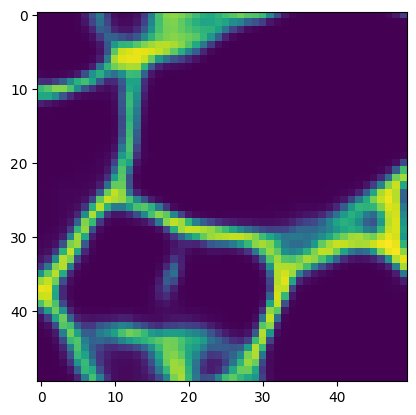

In [30]:
plt.figure()
plt.imshow(plantseg_small[0, 5])
plt.show()

# Do segmentation

In [31]:
segmentation_process(z)

(15, 50, 50)
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 28 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 82
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.152418
threshold exceeded
merged 0 edges
labels: 27
merging until threshold 100
merging until 100
min edge score 0.152418
merged 26 edges
extracting segmentation
(15, 50, 50)
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 27 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 79
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.106682
threshold exceeded
merged 0 edges
labels: 26
merging until threshold 100
merging until 100
min edge score 0.106682
merged 25 edges
extracting segmentation
(15, 50, 50)
Re-using alre

# Create candidate graph

In [13]:
candidate_graph = create_candidate_graph(file)

/
 ├── .zarr
 ├── Fragment_stats
 │   ├── Position
 │   │   ├── 0 (27, 4) int64
 │   │   ├── 1 (26, 4) int64
 │   │   └── 2 (38, 4) int64
 │   ├── Volume
 │   │   ├── 0 (27,) float64
 │   │   ├── 1 (26,) float64
 │   │   └── 2 (38,) float64
 │   └── id
 │       ├── 0 (27,) int64
 │       ├── 1 (26,) int64
 │       └── 2 (38,) int64
 ├── Fragments (3, 15, 50, 50) uint64
 ├── Merge_tree
 │   ├── Merge
 │   │   ├── 0 (26, 3) uint64
 │   │   ├── 1 (25, 3) uint64
 │   │   └── 2 (37, 3) uint64
 │   └── Scoring
 │       ├── 0 (26,) float64
 │       ├── 1 (25,) float64
 │       └── 2 (37,) float64
 ├── Raw (4, 3, 15, 50, 50) float64
 └── gt_trackimage (3, 15, 50, 50) uint64
frame: 0 / 2
-merged pre
-merged next
-added nodes pre
-added nodes next
-iterating over A&B
--iterating A: 0 / 53
--iterating A: 1 / 53
--iterating A: 2 / 53
--iterating A: 3 / 53
--iterating A: 4 / 53
--iterating A: 5 / 53
--iterating A: 6 / 53
--iterating A: 7 / 53
--iterating A: 8 / 53
--iterating A: 9 / 53
--iterating 

In [20]:
G = candidate_graph
#G.nodes(data=True)

In [21]:
nx.write_graphml(candidate_graph, '6_candidate_graph.graphml')

# Solve

In [22]:
for node in candidate_graph.nodes:
    if  candidate_graph.nodes[node]['parent'] == node:
        print(candidate_graph.nodes[node])

{'t': 0, 'z': 7, 'y': 24, 'x': 24, 'score': 0.9106910228729248, 'size': 37500, 'parent': 1319414159539965440, 'id': 1319414159539965440}
{'t': 1, 'z': 7, 'y': 24, 'x': 24, 'score': 0.9197472929954529, 'size': 37500, 'parent': 1319414159539965441, 'id': 1319414159539965441}
{'t': 2, 'z': 7, 'y': 24, 'x': 24, 'score': 0.8507391214370728, 'size': 37500, 'parent': 1319414159539965442, 'id': 1319414159539965442}


## Solve on test params

In [23]:
G = nx.read_graphml('6_candidate_graph.graphml')

In [24]:
roi = daisy.Roi((0, 0, 0, 0), (3, 15, 50, 50))

# input graph
graph = linajea.tracking.TrackGraph(G, frame_key='t', roi=roi)

# Params
ps = {
    "track_cost": 4.0,
    "weight_edge_score": -0.1,
    "weight_node_score": -0.1,
    "selection_constant": -1.0,
    "max_cell_move": 0.0,
    "block_size": [5, 100, 100, 100],
}
job = {"num_workers": 5, "queue": "normal"}

solve_config = linajea.config.SolveConfig(
    parameters=ps,
    job=job,
    context=[2, 100, 100, 100],
    solver_type = None,
    timeout = 100000)

In [25]:
config = SolvingConfig(solve_config)
constrs = get_constraints()

linajea.tracking.track(
                graph,
                config,
                frame_key='t',
                selected_key='selected',
                edge_indicator_costs=get_edge_indicator_costs,
                node_indicator_costs=get_node_indicator_costs,
                constraints_fns=constrs[0],
                pin_constraints_fns=constrs[1]
                )

Could not create Gurobi backend: Gurobi error in pylp/impl/solvers/GurobiBackend.cpp:22: No Gurobi license found (user daniel, host Daniels-Air-0469f8ed6246.home, hostid fa63c4e5, cores 8)


KeyError: 45071309499012096

In [19]:
nx.write_graphml(graph,'6.1_solution.graphml')

### Visualize

In [28]:
graph = nx.read_graphml('6.1_solution.graphml')

track_data, track_graph, cell_mask, fragments = anno.generate_tracks(z, graph)

In [29]:
import napari
viewer = napari.Viewer()
viewer.add_image(plantseg_small, name='Raw')
viewer.add_labels(fragments, name='Watershed Fragments')
viewer.add_labels(track_small, name='GT Track')
viewer.add_labels(cell_mask.astype(int), name='Predicted Track')

tracks = napari.layers.Tracks(track_data,   
                              graph=track_graph, 
                              name="track_test")
viewer.add_layer(tracks)


<Tracks layer 'track_test' at 0x2c0a73640>

### Evaluate

In [31]:
metrics, hota = evaluate_hota(track_small, cell_mask)

Error importing BURST due to missing underlying dependency: No module named 'tabulate'


In [32]:
print(hota.array_labels)
print(metrics)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
{'HOTA': array([0.68687326, 0.67269997, 0.67269997, 0.67269997, 0.63785793,
       0.60990219, 0.60990219, 0.60990219, 0.59601854, 0.57877157,
       0.57877157, 0.57069646, 0.56435197, 0.5204165 , 0.50687909,
       0.49469762, 0.48733972, 0.48733972, 0.44447832]), 'DetA': array([0.53846154, 0.51515152, 0.51515152, 0.51515152, 0.47058824,
       0.44927536, 0.44927536, 0.44927536, 0.42857143, 0.4084507 ,
       0.4084507 , 0.38888889, 0.36986301, 0.31578947, 0.2987013 ,
       0.26582278, 0.25      , 0.25      , 0.2195122 ]), 'AssA': array([0.87619048, 0.87843137, 0.87843137, 0.87843137, 0.86458333,
       0.82795699, 0.82795699, 0.82795699, 0.82888889, 0.82011494,
       0.82011494, 0.8375    , 0.86111111, 0.85763889, 0.86014493,
       0.92063492, 0.95      , 0.95      , 0.9       ]), 'DetRe': array([0.76086957, 0.73913043, 0.73913043, 0.73913043, 0.69565217,
       0.67391304, 0.6739130

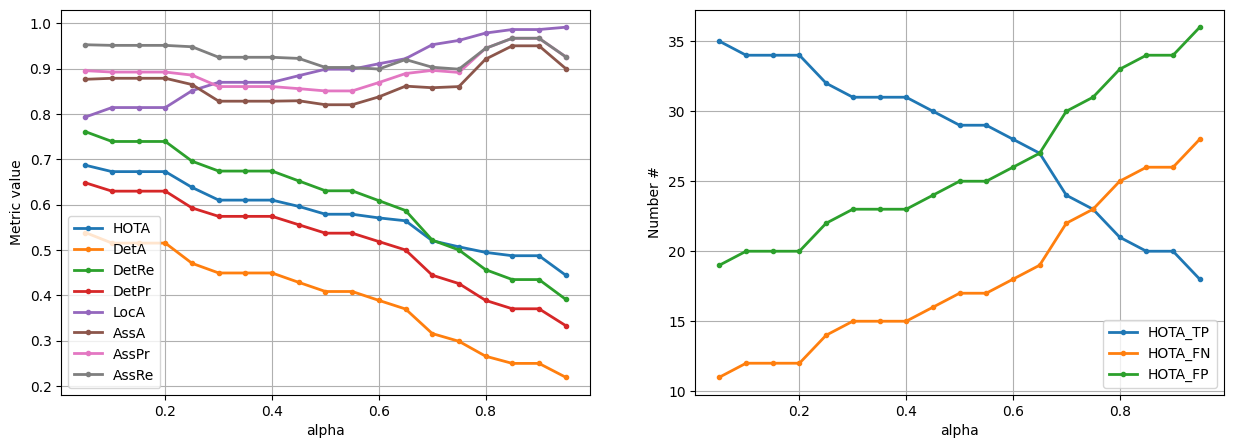

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota.array_labels, [s for s in metrics[m]], '.-', lw=2, label=m)
	
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota.array_labels, [s for s in metrics[m]], '.-', lw=2, label=m)
    
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('6.1_hota_metrics_linajea.png')

## ParameterGrid Search solver params

In [147]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [156]:
import json

def linajea_solve_graph(G, roi, ps, graph_i):
    _graph = linajea.tracking.TrackGraph(G, frame_key='t', roi=roi)

    job = {"num_workers": 5, "queue": "normal"}

    solve_config = linajea.config.SolveConfig(
        parameters=ps,
        job=job,
        context=[2, 100, 100, 100],
        solver_type = None,
        timeout = 100000)

    config = SolvingConfig(solve_config)
    constrs = get_constraints()

    # Solve
    linajea.tracking.track(
        _graph,
        config,
        frame_key='t',
        selected_key='selected',
        edge_indicator_costs=get_edge_indicator_costs,
        node_indicator_costs=get_node_indicator_costs,
        constraints_fns=constrs[0],
        pin_constraints_fns=constrs[1]
    )

    with open('linajea_results/params_%s.json' % graph_i, 'w') as outfile:
        outfile.write(json.dumps(ps))
        
    nx.write_graphml(_graph, 'linajea_results/solution_%s.graphml' % graph_i)

In [ ]:
roi = daisy.Roi((0, 0, 0, 0), (3, 15, 25, 25))

In [8]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'track_cost': [0.6, 1.0, 4.0, 5.0],
    'weight_edge_score': [-0.5, -0.3, -0.1, 0.1,0],
    'weight_node_score': [-0.5, -0.3, -0.1, 0.1],
    'selection_constant': [-1.0, -0.5, -0.1],
    'max_cell_move': [0.0, 0.5, 1.0],
    'block_size': [[5, 100, 100, 100]]
}
param = list(ParameterGrid(param_grid))
print(len(param))

720


### Run solver on all params

In [40]:
G = nx.read_graphml('6_candidate_graph.graphml')

for i, ps in enumerate(param):
    linajea_solve_graph(G, roi, ps, i)

### Evaluate results

In [3]:
metric_results = []
files = sorted(glob('linajea_results/*.graphml'))

In [4]:
for f in tqdm(files):
    # Load graph and annotate
    _g = nx.read_graphml(f)
    _, _, _cell_mask, _ = anno.generate_tracks(z, _g)

    # Evaluate
    metrics, _ = evaluate_hota(track_small, _cell_mask)

    metric_results.append((metrics['AssA'][9], metrics['AssA'][17],
         metrics['DetA'][9], metrics['DetA'][17],
         metrics['LocA'][9], metrics['LocA'][17],
         metrics['HOTA'][9], metrics['HOTA'][17]))

  0%|                                                   | 0/576 [00:00<?, ?it/s]


NameError: name 'z' is not defined

In [2]:
metric_results = np.array(metric_results)
best_sol_ass50 = np.argmax(metric_results[:,0])
best_sol_ass90 = np.argmax(metric_results[:,1])
best_sol_det50 = np.argmax(metric_results[:,2])
best_sol_det90 = np.argmax(metric_results[:,3])
best_sol_loc50 = np.argmax(metric_results[:,4])
best_sol_loc90 = np.argmax(metric_results[:,5])
best_sol_h50 = np.argmax(metric_results[:,6])
best_sol_h90 = np.argmax(metric_results[:,7])
best = np.unique(np.array([best_sol_h50,best_sol_h90,best_sol_det50,best_sol_det90,best_sol_loc50,best_sol_loc90,best_sol_ass50,best_sol_ass90]))

for i in best: print(i, ':', metric_results[i])

NameError: name 'metric_results' is not defined

### Visualize best results

In [8]:
# Load an annotate
_track_data_34, _, _cell_mask_34, _ = anno.generate_tracks(z, nx.read_graphml(files[34]))
_track_data_39, _, _cell_mask_39, _ = anno.generate_tracks(z, nx.read_graphml(files[39]))
_track_data_42, _, _cell_mask_42, _ = anno.generate_tracks(z, nx.read_graphml(files[42]))
_track_data_101, _, _cell_mask_101, _ = anno.generate_tracks(z, nx.read_graphml(files[101]))
_track_data_473, _, _cell_mask_473, _ = anno.generate_tracks(z, nx.read_graphml(files[473]))

In [6]:
# Visualize in napari
viewer = napari.Viewer()
viewer.add_image(plantseg_small, name='Raw')

viewer.add_labels(_cell_mask_34.astype(int), name='Predicted Track 34')
tracks_34 = napari.layers.Tracks(_track_data_34,
                              name="Track 34")
viewer.add_layer(tracks_34)

viewer.add_labels(_cell_mask_39.astype(int), name='Predicted Track 39')
tracks_39 = napari.layers.Tracks(_track_data_39,
                              name="Track 39")
viewer.add_layer(tracks_39)

viewer.add_labels(_cell_mask_42.astype(int), name='Predicted Track 42')
tracks_42 = napari.layers.Tracks(_track_data_42,
                              name="Track 42")
viewer.add_layer(tracks_42)

viewer.add_labels(_cell_mask_101.astype(int), name='Predicted Track 101')
tracks_101 = napari.layers.Tracks(_track_data_101,
                              name="Track 101")
viewer.add_layer(tracks_101)

viewer.add_labels(_cell_mask_473.astype(int), name='Predicted Track 473')
tracks_473 = napari.layers.Tracks(_track_data_473,
                              name="Track 473")
viewer.add_layer(tracks_473)

NameError: name 'files' is not defined

In [147]:
print(files[34])
print(files[39])
print(files[42])
print(files[101])
print(files[473])

linajea_results/solution_129.graphml
linajea_results/solution_133.graphml
linajea_results/solution_136.graphml
linajea_results/solution_19.graphml
linajea_results/solution_524.graphml


In [9]:
metrics_34, hota = evaluate_hota(track_small, _cell_mask_34)
metrics_39, hota = evaluate_hota(track_small, _cell_mask_39)
metrics_42, hota = evaluate_hota(track_small, _cell_mask_42)
metrics_101, hota = evaluate_hota(track_small, _cell_mask_101)
metrics_473, hota = evaluate_hota(track_small, _cell_mask_473)

Error importing BURST due to missing underlying dependency: No module named 'tabulate'


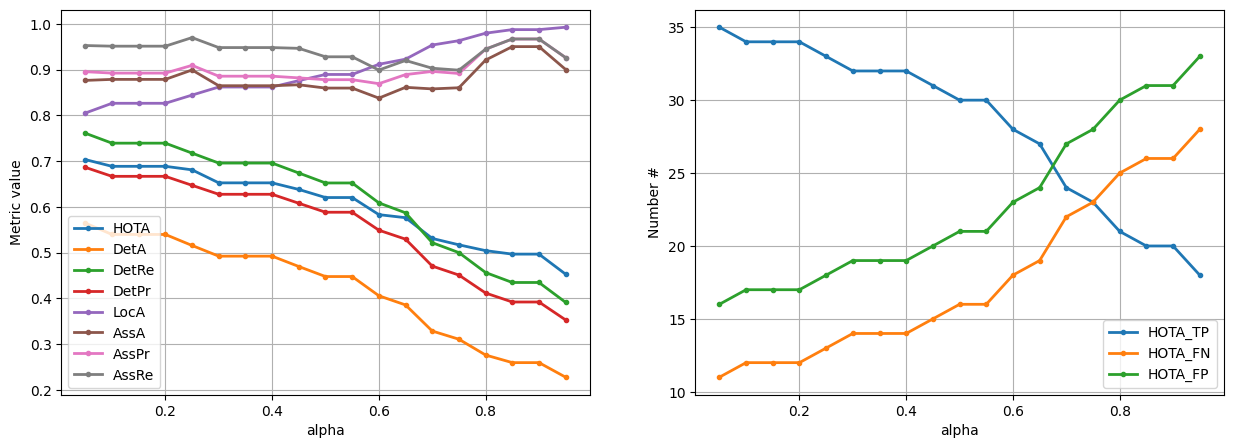

In [153]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota.array_labels, [s for s in metrics_34[m]], '.-', lw=2, label=m)
	
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota.array_labels, [s for s in metrics_34[m]], '.-', lw=2, label=m)
    
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('6.2_hota_metrics_linajea_p34.png')

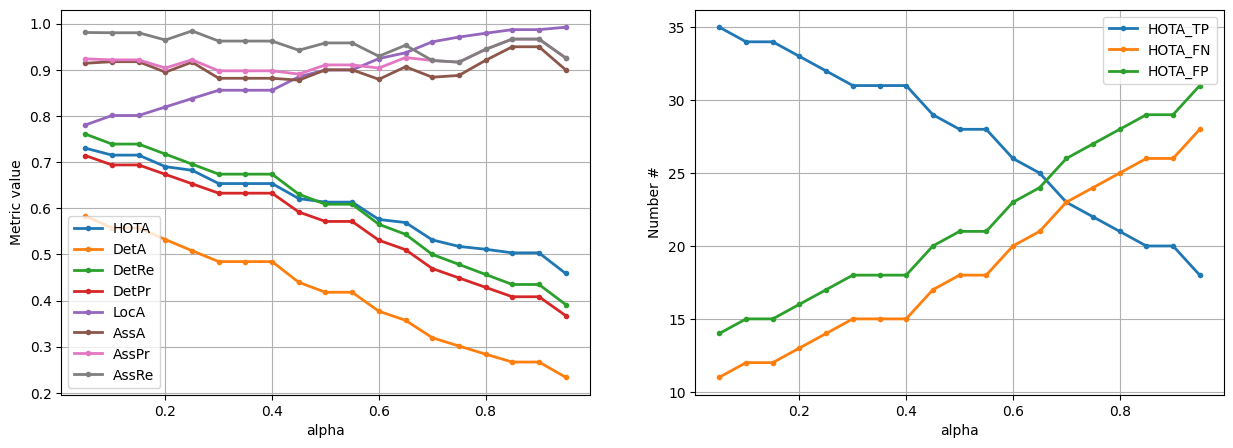

In [154]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota.array_labels, [s for s in metrics_39[m]], '.-', lw=2, label=m)
	
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota.array_labels, [s for s in metrics_39[m]], '.-', lw=2, label=m)
    
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('6.2_hota_metrics_linajea_p39.png')

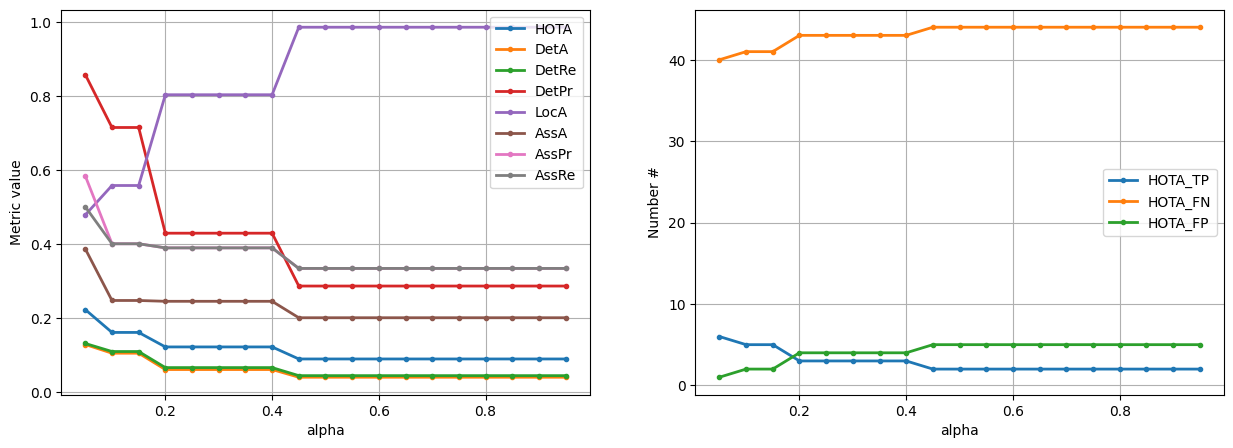

In [156]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('HOTA', 'DetA', 'DetRe', 'DetPr', 'LocA', 'AssA', 'AssPr', 'AssRe'):
    ax1.plot(hota.array_labels, [s for s in metrics_473[m]], '.-', lw=2, label=m)
	
ax1.set_xlabel(r'alpha')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('HOTA_TP', 'HOTA_FN', 'HOTA_FP'):
    ax2.plot(hota.array_labels, [s for s in metrics_473[m]], '.-', lw=2, label=m)
    
ax2.set_xlabel(r'alpha')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()
plt.savefig('6.2_hota_metrics_linajea_p473.png')

## Pickle all metrics

In [14]:
import pickle
pickle.dump({
    'p34': metrics_34,
    'p39': metrics_39,
    'p42': metrics_42,
    'p101': metrics_101,
    'p473': metrics_473,
    'array_labels': hota.array_labels
}, open( '6_all_metrics.pkl', 'wb' ) )